In [36]:
import os
import numpy as np
import pandas as pd
import numpy.random as rnd
import seaborn as sns
from matplotlib import animation
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sys import platform
import inspect
import arviz as az

az.style.use('arviz-darkgrid')
az.rcParams['plot.max_subplots'] = 50

In [37]:
# Read the data
#set current working directory to where this file is saved
thisdir = globals()['_dh'][0] + "\\" 
os.chdir(thisdir)

if platform == "darwin": 
    # OS X / Mac
    os.environ["PATH"] += os.pathsep + "/usr/local/bin"
elif platform == "win32":
    # Windows
    pass

#path = "/Users/donaldbrown/Dropbox/department/Classes/DS6014/CourseraBayesianML/Week4MCMC/"
file = "2krolls_plus_data.csv"

data = pd.read_csv(file)
# drop adv due to potential dependence
#data = data.drop("adv", axis=1)
data.head()

id  roll        adv stat         basis    type
0   0     5       none  STR     dexterity    save
1   1    11       none  DEX     dexterity    save
2   2    20  advantage  DEX  constitution   check
3   3     7       none  DEX      strength   check
4   4     3       none  WIS         melee  attack

In [38]:
file2 = "TravisRollsDataset.csv"

data2 = pd.read_csv(file2)
data2.head()

id  season  episode  roll  mod          basis    type        adv critical  \
0   2       3        1    13    0         wisdom    save       none     none   
1   3       3        1    17    0  investigation   check       none     none   
2   4       3        1     4    2      dexterity    save       none     none   
3   6       3        2    16    7          melee  attack       none     none   
4   7       3        2    16    7          melee  attack  advantage     none   

     stat  
0     WIS  
1     INT  
2     DEX  
3  ATTACK  
4  ATTACK

In [39]:
# create a column to delineate between simulated data and Travis' rolls
# 0 is a Travis roll
#deter = [0] * len(data2)
data2["deter"] = 0

# 1 is a generated roll
#deter = [1] * len(data)
data["deter"] = 1

In [40]:
# # make list of column names
# 
# col_names.remove("Unnamed: 0")
# col_names.remove("basis_type")
# col_names

In [41]:
# pick out shared columns
col_names = list(data.columns)
merge1 = data[col_names]
merge2 = data2[col_names]

# merge the datasets
total_data_rodeo = pd.concat([merge1, merge2], axis=0).reset_index()

# shuffle the data 3x in replicable way
rodeo = total_data_rodeo.sample(frac=1, random_state=1234567).reset_index(drop=True)
rodeo = rodeo.sample(frac=1, random_state=57389).reset_index(drop=True)
rodeo = rodeo.sample(frac=1, random_state=98754).reset_index(drop=True)
rodeo = rodeo[col_names]

In [42]:
# put rolls into bins
rodeo["rollbins"] = pd.cut(rodeo.roll, bins=[0, 8, 15, 20], labels=[0,1,2])

def assess_important(x):
    if x['adv']=="disadvantage" or x['basis'] in ["melee", "ranged", "dexterity", "strength"]:
        return 1
    else:
        return 0
rodeo['important'] = rodeo.apply(assess_important, axis=1)

In [43]:
# series_vals = [str(x) for x in rodeo['roll'].values.tolist()]
# cats = [str(x) for x in list(range(1,21))]

# rodeo['roll'] = pd.Categorical(series_vals, 
#                                    categories= cats,
#                                    ordered=False)
# rodeo["basis_type"] = rodeo["basis"].astype(str) + "_" + rodeo["type"].astype(str)

rodeo = rodeo.drop(["basis","type","id"], axis=1)

In [45]:
rodeo_dums = pd.get_dummies(rodeo[["adv", "stat", "important"]])
rodeo_dums = rodeo_dums[["adv_advantage", "adv_disadvantage", "stat_ATTACK"]]
rodeo_dums

adv_advantage  adv_disadvantage  stat_ATTACK
0                 0                 0            0
1                 0                 0            0
2                 0                 1            0
3                 0                 0            0
4                 0                 0            0
...             ...               ...          ...
2165              0                 0            0
2166              0                 0            0
2167              0                 0            0
2168              0                 0            0
2169              0                 0            0

[2170 rows x 3 columns]

In [46]:
determination = rodeo["deter"]
rolls = rodeo["roll"]
rollbins = rodeo["rollbins"]

In [47]:
rodeo_dums.columns

Index(['adv_advantage', 'adv_disadvantage', 'stat_ATTACK'], dtype='object')

In [23]:
# # Build the model with priors and run the sampling
# with pm.Model() as chd_model:
    
#     # Intercept term & prior
#     beta0 = pm.Normal("beta0", mu=0, sd=1)
#     # Beta coefficients for predictor variables & priors
#     beta = pm.MvNormal("beta", mu=np.zeros(k), cov=np.eye(k), shape=k)
    
    
#     # Calculate the logit 
#     mu = beta0 + pm.math.dot(X, beta)
#     theta = pm.Deterministic("theta",  pm.invlogit(mu))
#     # Pass the logits to a Bernoulli outcome, with the observed data
#     y_hat = pm.Bernoulli("y_hat", p=theta, observed=y) 
    
#     # Sample
#     trace_main = pm.sample(10000, cores=1, tune=1000, init='adapt_diag', progressbar=True)


In [48]:
## https://docs.pymc.io/notebooks/GLM-linear.html

import pymc3 as pm
from pymc3 import  *

#copy the x and y values into new variables
ycol = rodeo.deter.copy()
#don't include die outcome column
xcols = rodeo_dums.copy() 

#collect count values
xcolumns = list(xcols.columns)
coeff_count = len(xcolumns)
die_side_count = rodeo.rollbins.nunique()

In [ ]:
with pm.Model() as hierarchical_model:

    # Priors for the model parameters
    # Gaussians for the means of the priors of the random intercepts and slopes
    mus = []
    for i in range(coeff_count):
        mus.append(pm.Normal("mu_"+str(i), mu=0., sd=1e5))
    
    # Half-Cauchy for the standard deviations of the priors 
    # of the random intercepts and slopes
    sigmas = []
    for i in range(coeff_count):
        sigmas.append(pm.HalfCauchy("sigma_"+str(i), 1e5))

    # Gaussian priors for random intercepts and slopes
    priors = []
    for i in range(coeff_count):
        priors.append(pm.Normal("prior_"+str(i), mu=mus[i], 
                            sd=sigmas[i], shape=die_side_count))
    
    # Linear model, initialize w intercept
    mu = priors[0][rollbins] 
    
    for die in range(1,coeff_count):
        mu += priors[die][rollbins] * xcols.iloc[:, die]
    
    # Transform outcome to probability
    theta = pm.Deterministic('theta', pm.invlogit(mu))
    y_hat = pm.Bernoulli('y_hat', p=theta, observed=ycol)
    
    # Sample the posterior
    hierarchical_trace = pm.sample(draws=500, #1000
                            step=pm.NUTS(target_accept=0.99), 
                            tune=2000) #5000

# with Model() as model:
#     # specify glm and pass in data. The resulting linear model, its likelihood and
#     # and all its parameters are automatically added to our model.
#     glm.linear.LinearComponent(x=xcols, y=ycol, intercept=True)
#     trace = sample(3000, cores=2) # draw 3000 posterior samples using NUTS sampling

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior_2, prior_1, prior_0, sigma_2, sigma_1, sigma_0, mu_2, mu_1, mu_0]


C:\Users\kipmc\miniconda3\envs\pymc3\lib\site-packages\arviz\plots\traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (25) is smaller than the number of variables to plot (2225), generating only 25 plots
  warnings.warn(


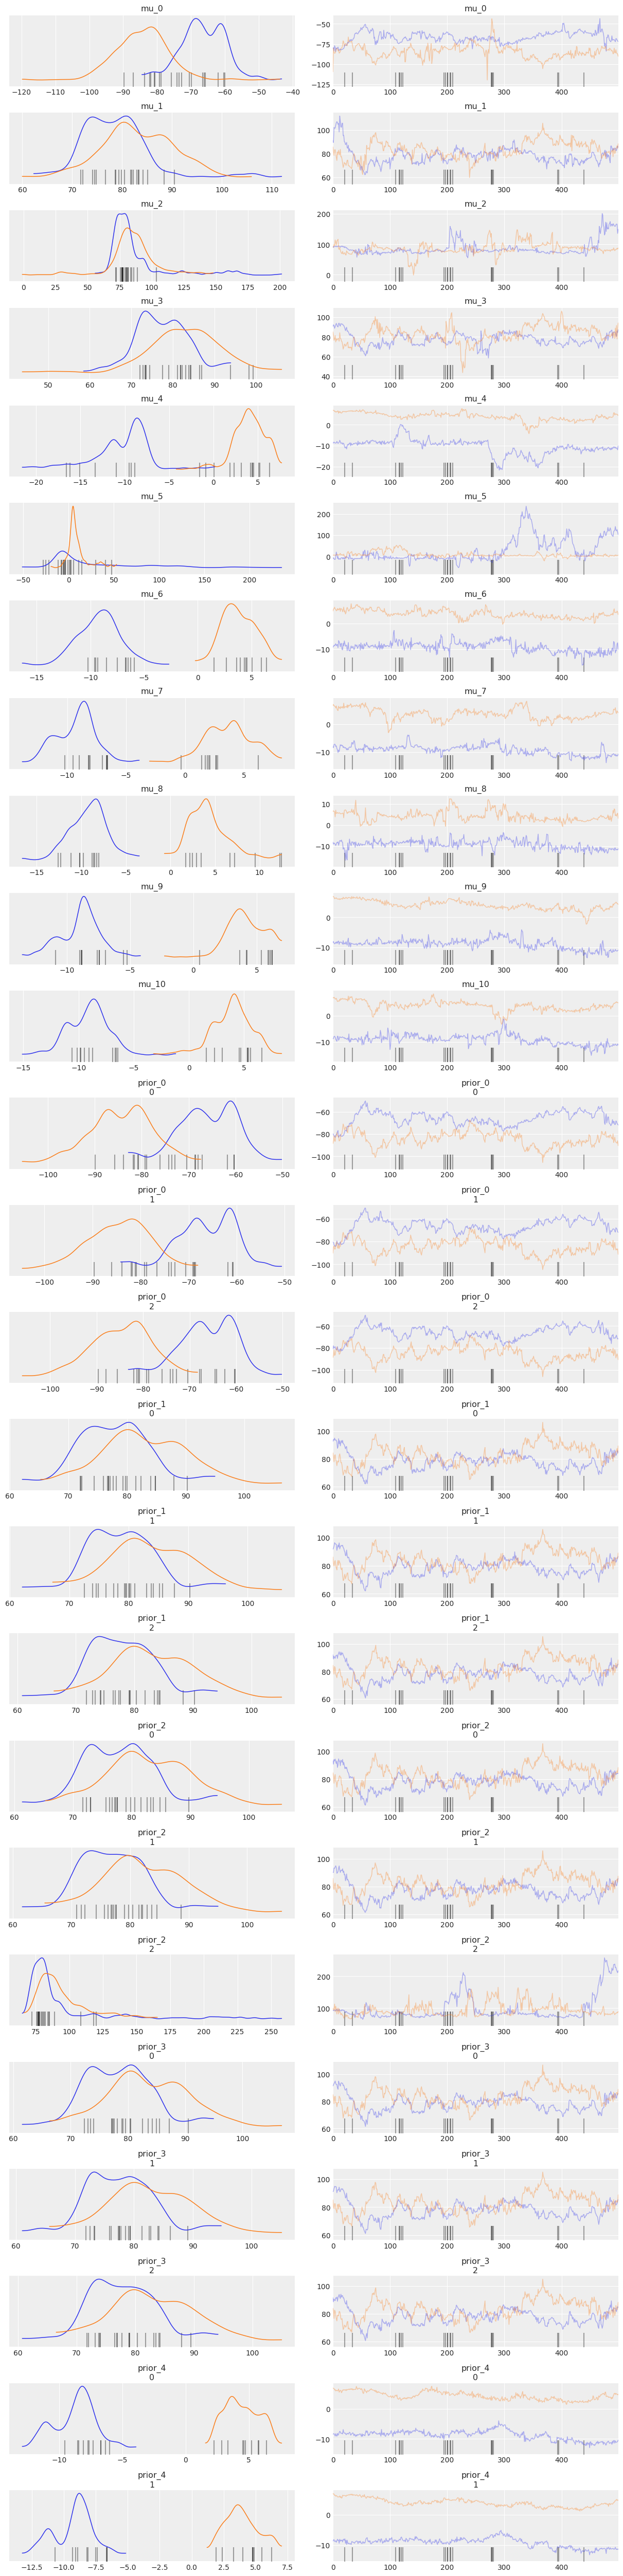

In [28]:
# Trace plots
with hierarchical_model:
    az.plot_trace(hierarchical_trace)

In [31]:
# Results in table
with hierarchical_model:
    main_idata = az.from_pymc3(hierarchical_trace)
    
azsum_df = az.summary(main_idata, round_to=2) #var_names=xcols.columns, 
azsum_df.sort_values(by=["r_hat"])

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
theta[1057]  0.94  0.02    0.91     0.98       0.00     0.00    623.00   
theta[1399]  0.97  0.01    0.95     0.99       0.00     0.00    235.51   
theta[1398]  0.95  0.03    0.91     0.99       0.00     0.00    754.81   
theta[1395]  0.89  0.02    0.86     0.92       0.00     0.00   1147.31   
theta[1394]  0.89  0.02    0.86     0.92       0.00     0.00   1147.31   
...           ...   ...     ...      ...        ...      ...       ...   
prior_10[0] -2.38  6.84  -11.58     6.92       4.73     3.97      2.09   
prior_4[2]  -2.62  6.84  -11.66     6.64       4.73     3.97      2.08   
prior_10[2] -2.16  6.85  -11.69     6.44       4.74     3.98      2.09   
prior_7[0]  -2.84  6.78  -11.97     6.17       4.69     3.94      2.09   
mu_4        -3.25  7.78  -15.07     7.18       5.27     4.38      2.18   

              ess_sd  ess_bulk  ess_tail  r_hat  
theta[1057]   621.96    608.86    717.91   1.00  
theta[1399]   234.45    218.00    391.86   1.00  
theta[1398]   746.17    634.92    474.98   1.00  
theta[1395]  1147.02   1135.23    956.16   1.00  
theta[1394]  1147.02   1135.23    956.16   1.00  
...              ...       ...       ...    ...  
prior_10[0]     2.09      2.56     11.99   2.24  
prior_4[2]      2.08      2.57     11.29   2.24  
prior_10[2]     2.09      2.57     12.01   2.24  
prior_7[0]      2.09      2.56     12.23   2.25  
mu_4            2.18      2.45     14.98   2.58  

[2225 rows x 11 columns]

<Figure size 600x1400 with 0 Axes>

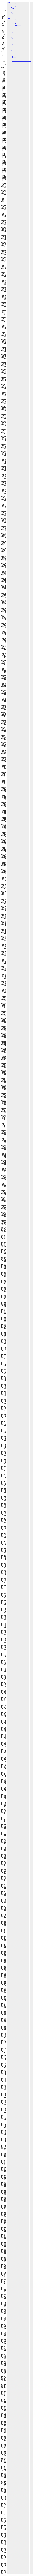

In [35]:
# Forest plots
plt.figure(figsize=(6,14))
with hierarchical_model:
    pm.forestplot(hierarchical_trace); #var_names=xcols.columns, , combined=True